### Load config and setup file

In [9]:
import xml.etree.ElementTree as ET
import json
from pathlib import Path

In [18]:
#input_path = "/Users/rodrse/Documents/DemandCalibration/package/calibrate_ods/network/SFO/metadata/"
#input_path = '/Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/metadata/'
input_path = '/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/metadata/'



In [108]:
#from sumo_python.helpers.load_experiment_metadata import load_experiment_metadata

In [19]:
import json 

def load_experiment_metadata(input_path: str):

    config = json.load(open(input_path + "/config.json"))
    config["NETWORK"] = Path(config["NETWORK"])
    config["SUMO"] = Path(config["SUMO"])
    # [CO] updated simulation setup to use OD scenario #4: 42-dimensional  + low congestion.
    sim_setup = json.load(open(input_path + "simulation_setups_co_gt.json"))

    return config, sim_setup


In [20]:

config, sim_setup = load_experiment_metadata(input_path)

sim_setup

{'objective': 'counts',
 'net': 'SFO.net.xml',
 'taz': 'taz.xml',
 'add': 'additional.add.xml',
 'start_sim_sec': 0,
 'end_sim_sec': 1800,
 'init_od': 'initOD_30minDemand.xml',
 'gt_od': 'initOD_30minDemand.xml',
 'n_sumo_replicate': 1,
 'prefix_gt': 'gt',
 'prefix_sim_run': 'current'}

In [21]:
config

{'NETWORK': PosixPath('/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO'),
 'SUMO': PosixPath('/usr/local/opt/sumo/share/sumo')}

### Check ground-truth OD matrix

In [30]:
net_path = config['NETWORK']

In [32]:
tree = ET.parse(f'{net_path}' + "/" + sim_setup['gt_od'])
root = tree.getroot()

od_mat = []
for taz_elem in root.iter('tazRelation'):
    od_mat.append([taz_elem.get('from'), taz_elem.get('to'), int(taz_elem.get('count'))])


In [33]:
import pandas as pd
df_od = pd.DataFrame(od_mat, columns=['tazFrom', 'tazTo', 'tazCount'])

In [34]:
df_od.shape

(45871, 3)

<AxesSubplot: >

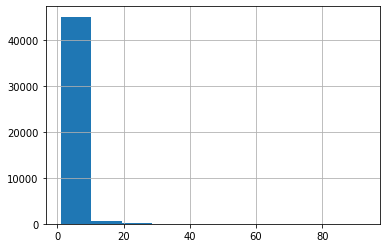

In [36]:
df_od.tazCount.hist()

In [41]:
df_od.tazFrom.unique()

array(['10100', '101100', '101200', ..., '982000', '983200', '984300'],
      dtype=object)

### Run GT simulations

In [22]:
import os

def run_sumo(config, sim_setup, prefix_input, prefix_output):
    od2trips_cmd = (
        #f"od2trips --no-step-log  --spread.uniform "
        f"od2trips  --spread.uniform "
        #Loads TAZ (districts)
        f"--taz-files {config['NETWORK']}/{sim_setup['taz']} " 
        # Loads O/D-matrix in tazRelation format fromFILE(s)
        f"--tazrelation-files {config['NETWORK']}/{sim_setup[f'{prefix_input}_od']} "
        # Writes trip definitions into FILE
        f"-o {config['NETWORK']}/{prefix_output}_od_trips.trips.xml " 
    )

    # Run SUMO to generate outputs
    sumo_run = (
        # Prefix which is applied to all output files. 
        f"sumo --output-prefix {prefix_output}_ " 
        # Do not check whether routes are connected
        f"--ignore-route-errors=true "
        # Load road network description from FILE
        f"--net-file={config['NETWORK']/sim_setup['net']} "
        # Load routes descriptions from FILE(s)
        f"--routes={config['NETWORK']}/{prefix_output}_od_trips.trips.xml "
        #  -b Defines the begin time in seconds; The simulation starts at this time
        # -e Defines the end time in seconds; The simulation ends at this time
        f"-b {sim_setup['start_sim_sec']} -e {sim_setup['end_sim_sec']} "
        # Load further descriptions from FILE(s)
        f"--additional-files {config['NETWORK']/sim_setup['add']} "
        f"--duration-log.statistics "
        f"--xml-validation never "
        # Save single vehicle route info into FILE
        f"--vehroutes {config['NETWORK']}/{prefix_output}_routes.vehroutes.xml "
        f"--verbose "
        # Disables output of warnings
        f"--no-warnings "
        # Faster simulation (i.e. less detailed)
        f"--mesosim true "
    
    )
        # f"--seed {seed}"

    try:
        print(od2trips_cmd)
        os.system(od2trips_cmd)
    except:
        print("Unable to create trips file")
    else:
        print("###### Running SUMO #######")
        print(sumo_run)
        os.system(sumo_run)


In [23]:
import time
print("###### GT #######")
start = time.time() 
run_sumo(config, sim_setup, prefix_input = "gt", prefix_output = "gtOut")
end = time.time()
print("Elapsed time: ", end - start)


###### GT #######
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/taz.xml --tazrelation-files /Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/initOD_30minDemand.xml -o /Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/gtOut_od_trips.trips.xml 
Success.time 1789.53
###### Running SUMO #######
sumo --output-prefix gtOut_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/SFO.net.xml --routes=/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/gtOut_od_trips.trips.xml -b 0 -e 1800 --additional-files /Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/additional.add.xml --duration-log.statistics --xml-validation never --vehroutes /Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/gtOut_routes.vehroutes.xml --verbose --no-warnings --mesosim true 
Loading net-file from '/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/SFO.net.xml' ... 
done (2516

### Read output for GT

In [24]:
# excluding warmup period of 15min
# so you need to simulate for at least 15min now. 
warm_up_sec = 15*60 # duration in seconds

# duration, in seconds, of each edge simulation output statistics
# this value should be consistent with what is defined in additional.add.xml
edge_stats_freq = 300

Scenario is simplified we aggregate all traffic stats over all time intervals simulated, excluding the warm-up period. We compute a single loss over that average aggregate statistic. So no longer looking at time-dependent statistics.

In [26]:
import os
import pandas as pd
from pandas import DataFrame
import numpy as np

def parse_loop_data_xml_to_pandas(config: dict,loop_file: dict) -> DataFrame: 
    """Read the Loop Detectors Data: Each SUMO run produces a file with the
    traffic counts. This function reads the corresponding traffic counts file
    averages across simulation replications
    
    """

    output_file =(config["NETWORK"] / "loopOutputs.csv")
    ## See output explanation:
    # https://sumo.dlr.de/docs/Simulation/Output/Lane-_or_Edge-based_Traffic_Measures.html#generated_output

    data2csv = (
        f"python {config['SUMO']}/tools/xml/xml2csv.py "
        f"{loop_file} "
        f"-o {output_file}"
        )
    
    os.system(data2csv)
    
    df_trips = pd.read_csv(output_file, sep=";", header=0)

    # edge flow in vehicles per hour
    ## edge speed is given in m/s
    ## edge_density is given in no. of vehicles/km

    df_trips['interval_nVehContrib'] = df_trips['edge_arrived'] + df_trips['edge_left']
    #df_trips['interval_nVehContrib'] = 3.6*df_trips['edge_speed']*df_trips['edge_density']


    #df_trips['EdgeID'] = df_trips['edge_id']

    # edge speed is given in m/s
    # computed only for edges that have departed flow
    df_trips['interval_harmonicMeanSpeed'] = df_trips[df_trips['interval_nVehContrib']>0]['edge_speed']
    
    # exclude warm-up period
    df_trips = df_trips[df_trips['interval_begin']>warm_up_sec]

    # aggregate the rest of the time intervals
    df_trips = df_trips[df_trips['interval_begin']>warm_up_sec]
    df_agg = df_trips.groupby(by=['edge_id'], as_index=False).agg(
        {'interval_nVehContrib':np.sum, 'interval_harmonicMeanSpeed':np.mean})


    return df_agg, df_trips

In [27]:
loop_stats_df_gt, df_trips_gt = parse_loop_data_xml_to_pandas(
    config,
    loop_file = "../../network/SFO/gt_edge_data_SFO.xml"
)


In [28]:
loop_stats_df_gt.head()

,edge_id,interval_nVehContrib,interval_harmonicMeanSpeed
0,-100134682#0,7,14.92
1,-100134703#0,4,7.27
2,-100134703#1,3,7.15
3,-100217518,1,4.73
4,-100217520#4,0,NaN


In [29]:
df_trips_gt

,interval_begin,interval_end,interval_id,edge_arrived,edge_density,edge_departed,edge_entered,edge_id,edge_laneChangedFrom,edge_laneChangedTo,...,edge_occupancy,edge_overlapTraveltime,edge_sampledSeconds,edge_speed,edge_speedRelative,edge_timeLoss,edge_traveltime,edge_waitingTime,interval_nVehContrib,interval_harmonicMeanSpeed
340932,1200.0,1500.0,dump_10,0,1.10,0,5,-100134682#0,0,0,...,0.55,10.11,48.88,15.16,1.10,0.00,9.78,0.0,5,15.16
340933,1200.0,1500.0,dump_10,0,1.83,1,3,-100134703#0,0,0,...,0.92,11.96,45.09,7.27,1.06,0.00,11.27,0.0,4,7.27
340934,1200.0,1500.0,dump_10,0,1.40,0,3,-100134703#1,0,0,...,0.70,12.18,34.45,7.15,1.04,0.00,11.48,0.0,3,7.15
340935,1200.0,1500.0,dump_10,1,0.70,0,1,-100217518,0,0,...,0.35,4.32,3.27,4.73,1.06,0.00,3.27,0.0,1,4.73
340936,1200.0,1500.0,dump_10,0,6.17,1,23,-100400941#2,0,0,...,3.08,11.84,271.68,12.82,0.93,6.97,11.45,0.0,23,12.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546879,1500.0,1800.0,dump_10,2,0.94,0,4,99278924#8,0,0,...,0.47,6.42,24.26,14.15,1.03,0.00,6.06,0.0,4,14.15
546880,1500.0,1800.0,dump_10,0,0.23,0,1,99278924#9,0,0,...,0.11,7.05,6.71,14.52,1.05,0.00,6.71,0.0,1,14.52
546881,1500.0,1800.0,dump_10,0,0.50,0,2,99393122,0,0,...,0.13,6.20,11.64,13.26,0.96,0.00,5.82,0.0,2,13.26
546882,1500.0,1800.0,dump_10,0,0.17,0,1,99425743#0,0,0,...,0.09,3.19,2.94,19.46,1.00,0.00,2.94,0.0,1,19.46


### Create and simulate a small variation of that GT OD
Find an edge with counts that are not too low. Change the demand of the main OD pair that contributes to traffic on that edge. 

In [119]:
df_trips_gt.head()

,interval_begin,interval_end,interval_id,edge_arrived,edge_density,edge_departed,edge_entered,edge_id,edge_laneChangedFrom,edge_laneChangedTo,...,edge_occupancy,edge_overlapTraveltime,edge_sampledSeconds,edge_speed,edge_speedRelative,edge_timeLoss,edge_traveltime,edge_waitingTime,interval_nVehContrib,interval_harmonicMeanSpeed
340932,1200.0,1500.0,dump_10,0,1.10,0,5,-100134682#0,0,0,...,0.55,10.11,48.88,15.16,1.10,0.00,9.78,0.0,5,15.16
340933,1200.0,1500.0,dump_10,0,1.83,1,3,-100134703#0,0,0,...,0.92,11.96,45.09,7.27,1.06,0.00,11.27,0.0,4,7.27
340934,1200.0,1500.0,dump_10,0,1.40,0,3,-100134703#1,0,0,...,0.70,12.18,34.45,7.15,1.04,0.00,11.48,0.0,3,7.15
340935,1200.0,1500.0,dump_10,1,0.70,0,1,-100217518,0,0,...,0.35,4.32,3.27,4.73,1.06,0.00,3.27,0.0,1,4.73
340936,1200.0,1500.0,dump_10,0,6.17,1,23,-100400941#2,0,0,...,3.08,11.84,271.68,12.82,0.93,6.97,11.45,0.0,23,12.82


In [ ]:
loop_stats_df_gt.head()

,edge_id,interval_nVehContrib,interval_harmonicMeanSpeed
0,-100134682#0,1,12.950
1,-100217522,1,3.770
2,-100400941#2,7,12.315
3,-100400941#5,12,13.410
4,-100677749#10,1,14.080


<AxesSubplot: >

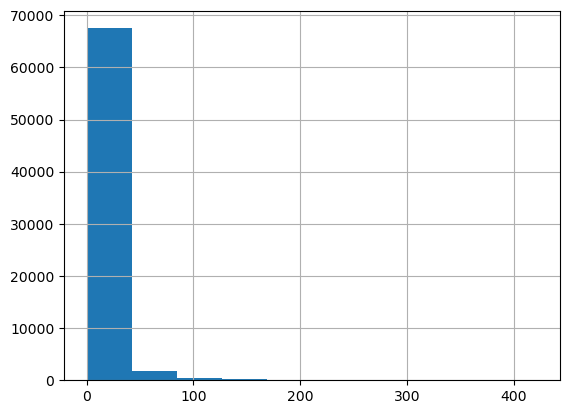

In [100]:
loop_stats_df_gt.interval_nVehContrib.hist()

In [102]:
loop_stats_df_gt[loop_stats_df_gt.interval_nVehContrib>50]

,edge_id,interval_nVehContrib,interval_harmonicMeanSpeed
102,-111547662#1,54,10.990
851,-162931811#3,154,12.670
1412,-210709486#5,70,13.445
1420,-214545530#2,179,12.585
1421,-214545530#3,175,13.090
...,...,...,...
69539,93539067-AddedOnRampEdge,98,26.515
69852,95002419,51,10.765
70141,9676975,102,23.745
70179,9898614-AddedOffRampEdge,72,21.385


In [103]:
loop_stats_df_gt.interval_nVehContrib.max()

422

In [104]:
loop_stats_df_gt[loop_stats_df_gt.interval_nVehContrib == 422]

,edge_id,interval_nVehContrib,interval_harmonicMeanSpeed
65985,8921938,422,18.225
65986,8921938-AddedOffRampEdge,422,19.630


Choosing edge_id 8921938 as the single GT edge id, for debugging. 

In [52]:
GT_edge_id = '8921938'

In [148]:
# get the origin and destination tazes of the trips that traveled through GT_edge_id

tree = ET.parse(f'{net_path}gt_routes.vehroutes.xml')
root = tree.getroot()

# first get the origin and destination edges of the corresponding routes
all_orig_edge = []
all_dest_edge = []
for r1 in root.iter("routes"):
    for veh in r1.iter("vehicle"):
        for rte in veh.iter("route"):
            if GT_edge_id in rte.get('edges'):
                all_edges = rte.get('edges').split(' ')
                all_orig_edge.append(all_edges[0])
                all_dest_edge.append(all_edges[-1])
                

In [157]:
# then we find the tazes of those origin and destination edges

tree = ET.parse(f'{net_path}taz.xml')
root = tree.getroot()

all_orig_taz = []
all_dest_taz = []

for orig1 in all_orig_edge:
    bool_edge = True # used to only account for 1 taz per edge
    for tazs1 in root.iter("tazs"):
        for taz1 in tazs1.iter("taz"):
            if (orig1 in taz1.get('edges')) and bool_edge:
                all_orig_taz.append(taz1.get('id'))
                bool_edge = False

for dest1 in all_dest_edge:
    bool_edge = True # used to only account for 1 taz per edge
    for tazs1 in root.iter("tazs"):
        for taz1 in tazs1.iter("taz"):
            if (dest1 in taz1.get('edges')) and bool_edge:
                all_dest_taz.append(taz1.get('id'))
                bool_edge = False



In [158]:
len(all_orig_edge), len(all_dest_edge), len(all_orig_taz), len(all_dest_taz)

(167, 167, 167, 167)

In [160]:
df_taz = pd.DataFrame({'orig_taz':all_orig_taz, 'dest_taz':all_dest_taz})

In [167]:
df_taz = df_taz.groupby(['orig_taz', 'dest_taz']).size().reset_index().rename(columns={0:'occurence'})

In [168]:
df_taz['occurence'].max()

10

In [169]:
df_taz.shape

(136, 3)

In [170]:
df_taz[df_taz['occurence']==10]

,orig_taz,dest_taz,occurence
45,401700,61500,10


Now slightly changing the demand of OD pair: (401700,61500)

In [171]:
net_path = '/Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/'

create new OD that differs only slightly from GT OD

In [174]:
# same average hourly demand as the initial SFO OD but now set for 30min of simulation
# initial xml is the above defined hourly OD (to make the xml tree parsing faster)
tree = ET.parse(f'{net_path}initOD_30minDemand.xml')
root = tree.getroot()
    
num_removed = 0
for interv in root.findall("interval"):
    for child in interv.findall("tazRelation"):
        if (child.get('from') == "401700") and (child.get('to') == "61500"):
            print('initial demand:', child.get('count'))
            child.set('count',str(20))
            print('new demand:', child.get('count'))
tree.write(f'{net_path}initOD_30minDemand_v2.xml')

initial demand: 14
new demand: 20


In [177]:
def load_experiment_metadata(input_path: str):

    config = json.load(open(input_path + "/config.json"))
    config["NETWORK"] = Path(config["NETWORK"])
    config["SUMO"] = Path(config["SUMO"])
    # [CO] updated simulation setup to use OD scenario #4: 42-dimensional  + low congestion.
    sim_setup = json.load(open(input_path + "simulation_setups_co_gt_v2.json"))

    return config, sim_setup

In [178]:

config_v2, sim_setup_v2 = load_experiment_metadata(input_path)

sim_setup_v2

{'objective': 'counts',
 'net': 'SFO.net.xml',
 'taz': 'taz.xml',
 'add': 'additional.add.xml',
 'start_sim_sec': 0,
 'end_sim_sec': 1800,
 'init_od': 'initOD_30minDemand_v2.xml',
 'gt_od': 'initOD_30minDemand_v2.xml',
 'n_sumo_replicate': 1,
 'prefix_gt': 'gtv2_',
 'prefix_sim_run': 'current'}

Simulate the new OD

In [198]:
import time
print("###### GT #######")
start = time.time() 
run_sumo(config_v2, sim_setup_v2, prefix_input="gt",  prefix_output= "gtv2")
end = time.time()
print("Elapsed time: ", end - start)

###### GT #######
od2trips  --spread.uniform --taz-files /Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/taz.xml --tazrelation-files /Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/initOD_30minDemand_v2.xml -o /Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/gtv2_od_trips.trips.xml 
Success.time 1789.53
###### Running SUMO #######
sumo --output-prefix gtv2_ --ignore-route-errors=true --net-file=/Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/SFO.net.xml --routes=/Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/gtv2_od_trips.trips.xml -b 0 -e 1800 --additional-files /Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/additional.add.xml --duration-log.statis

In [199]:
loop_stats_df_gt_v2, _ = parse_loop_data_xml_to_pandas(
    config_v2,
    loop_file = "../../network/SFO/gtv2_edge_data_SFO.xml"
)


### Compute loss given output

In [200]:
import numpy as np


def compute_nrmse_counts_one_edge(df_true, df_simulated,GT_edge_id):
    # Merge simulated output with ground truth
    df1 = df_true\
        .merge(df_simulated, on=['edge_id'],
        suffixes=('_GT', '_sim'), how='left')
    
    # only consider GT_edge_id of interest
    df1 = df1[df1['edge_id']==GT_edge_id]

    df1['interval_nVehContrib_sim'] = df1['interval_nVehContrib_sim'].fillna(0)
        
    df1['diff_square'] = (
        df1['interval_nVehContrib_GT'] - df1['interval_nVehContrib_sim']
        )**2
    
    n = df1.shape[0]
    print(n)
    print(df_true.shape[0])
    print(df_simulated.shape[0])
    RMSN = np.sqrt(n*(df1['diff_square'].sum()))/df1['interval_nVehContrib_GT'].sum()

    return RMSN


def compute_nrmse_counts_all_edges(df_true, df_simulated):
    # Merge simulated output with ground truth
    df1 = df_true\
        .merge(df_simulated, on=['edge_id'],
        suffixes=('_GT', '_sim'), how='left')
    
    df1['interval_nVehContrib_sim'] = df1['interval_nVehContrib_sim'].fillna(0)
        
    df1['diff_square'] = (
        df1['interval_nVehContrib_GT'] - df1['interval_nVehContrib_sim']
        )**2
    
    n = df1.shape[0]
    print(n)
    print(df_true.shape[0])
    print(df_simulated.shape[0])
    RMSN = np.sqrt(n*(df1['diff_square'].sum()))/df1['interval_nVehContrib_GT'].sum()

    return RMSN



In [201]:
compute_nrmse_counts_one_edge(loop_stats_df_gt, loop_stats_df_gt_v2, GT_edge_id)

1
121057
120909


0.017937219730941704

In [202]:
compute_nrmse_counts_all_edges(loop_stats_df_gt, loop_stats_df_gt_v2)

121057
121057
120909


0.27158024725755964

In [203]:
# simulation stats of GT_edge_id
loop_stats_df_gt[loop_stats_df_gt.edge_id == GT_edge_id]

,edge_id,interval_nVehContrib,interval_harmonicMeanSpeed
111456,8921938,223,19.09


In [204]:
loop_stats_df_gt_v2[loop_stats_df_gt_v2.edge_id == GT_edge_id]

,edge_id,interval_nVehContrib,interval_harmonicMeanSpeed
111337,8921938,219,18.705


In [18]:
loop_stats_df_current.shape

(200424, 23)

In [19]:
loop_stats_df_current.head()

,interval_begin,interval_end,interval_id,edge_arrived,edge_density,edge_departed,edge_entered,edge_id,edge_laneChangedFrom,edge_laneChangedTo,...,edge_overlapTraveltime,edge_sampledSeconds,edge_speed,edge_speedRelative,edge_timeLoss,edge_traveltime,edge_waitingTime,interval_nVehContrib,interval_harmonicMeanSpeed,EdgeID
0,14400.0,14700.0,dump_10,0,2.15,0,9,-100134682#0,0,0,...,11.00,95.76,13.92,1.01,0.8,10.64,0.0,107.74080,13.92,-100134682#0
1,14400.0,14700.0,dump_10,0,0.55,0,1,-100134703#0,0,0,...,14.41,13.59,6.04,0.88,0.0,13.58,0.0,11.95920,6.04,-100134703#0
2,14400.0,14700.0,dump_10,0,0.55,0,1,-100134703#1,0,0,...,14.43,13.60,6.04,0.88,0.0,13.60,0.0,11.95920,6.04,-100134703#1
3,14400.0,14700.0,dump_10,0,0.45,1,0,-100267303,0,0,...,4.60,3.92,7.37,1.08,0.0,3.92,0.0,11.93940,7.37,-100267303
4,14400.0,14700.0,dump_10,0,1.38,0,6,-100400941#2,0,0,...,10.92,60.68,13.91,1.01,0.0,10.56,0.0,69.10488,13.91,-100400941#2


### Manually compute loss: departed + entered -arrived - left

In [39]:
def compute_nrmse_counts_new(df_true, df_simulated):
    # Merge simulated output with ground truth
    df_true["y"] = df_true['edge_departed'] + \
            df_true['edge_entered'] - \
            df_true['edge_arrived'] - \
            df_true['edge_left'] 

    df_simulated["y"] = df_simulated['edge_departed'] + \
            df_simulated['edge_entered'] - \
            df_simulated['edge_arrived'] - \
            df_simulated['edge_left']         

    df1 = df_true\
        .merge(df_simulated, on=['EdgeID', 'interval_begin', 'interval_end'],
        suffixes=('_GT', '_sim'), how='left')
    
    df1['y_sim'] = df1['y_sim'].fillna(0)            
    
    df1['diff_square'] = (
        df1['y_GT'] - df1['y_sim']
        )**2
    
    n = df1.shape[0]
    print(n)
    print(df_true.shape[0])
    print(df_simulated.shape[0])
    RMSN = np.sqrt(n*(df1['diff_square'].sum()))/df1['interval_nVehContrib_GT'].sum()

    return RMSN


In [40]:
compute_nrmse_counts_new(loop_stats_df_init, loop_stats_df_current)


200571
200571
200424


0.011312367053198177